In [4]:
from sprint.task_vector_utils import load_tasks

tasks = load_tasks()
task_names = list(tasks.keys())

Cloning into 'data/itv'...


In [7]:
for task_name in ['person_profession']:
    !python attn_linear_effects_full_block.py {task_name}   

source {'present_simple_gerund': [8446], 'present_simple_past_perfect': [19628], 'plural_singular': [29228], 'algo_last': [29228], 'location_country': [11459], 'location_continent': [11459], 'person_profession': [26436], 'football_player_position': [19916], 'present_simple_past_simple': [21327], 'es_en': [31123], 'fr_en': [31123], 'it_en': [31123], 'country_capital': [13529], 'antonyms': [11050], 'singular_plural': [1322], 'person_language': [1132], 'algo_second': [32115], 'algo_first': [32115], 'location_religion': [3466], 'en_fr': [7928], 'en_it': [7928], 'location_language': [10884], 'en_es': [99]}
target {'present_simple_gerund': [15554], 'present_simple_past_perfect': [15356], 'plural_singular': [2930], 'algo_last': [8633], 'location_country': [7967], 'location_continent': [19260], 'person_profession': [18416], 'football_player_position': [9790], 'present_simple_past_simple': [15356], 'es_en': [5579], 'fr_en': [16490], 'it_en': [5579], 'country_capital': [11173], 'antonyms': [1161

fatal: destination path 'data/itv' already exists and is not an empty directory.
person_profession 821
821
Setting up masks...
Running metrics...
Setting up RMS...
100%|███████████████████████████████████████████| 18/18 [00:04<00:00,  4.04it/s]
Loading SAEs...
100%|█████████████████████████████████████████████| 2/2 [00:16<00:00,  8.05s/it]
Running node IEs...
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]
Max activation for 12 32417 0.0
Skipping 26436 32417 (no activations)
Max activation for 12 15554 0.0
Skipping 26436 15554 (no activations)
Max activation for 12 11618 0.0
Skipping 26436 11618 (no activations)
Max activation for 12 11172 0.0
Skipping 26436 11172 (no activations)
Max activation for 12 11173 0.0
Skipping 26436 11173 (no activations)
Max activation for 12 19260 0.0
Skipping 26436 19260 (no activations)
Skipping 26436 6756 (no high proportion)
Max activation for 12 16490 0.0
Skipping 26436 16490 (no activations)
Max activation for 12 5579

In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("../..")           

In [21]:
    import json
    import pandas as pd
    import numpy as np


    with open("micrlhf-progress/attn_results_3.jsonl") as f:
        results = [json.loads(line) for line in f]

    # results = pd.DataFrame(tmp_results)

    all_tasks = results["task"].unique().tolist()
    all_detectors = results["source"].unique().tolist()
    all_executors = results["target"].unique().tolist()

    from plotly.subplots import make_subplots
    import plotly.express as px
    import plotly.graph_objects as go

    side = int(np.ceil(np.sqrt(len(all_tasks))).astype(int))

    print(side)

    fig = make_subplots(rows=side, cols=side, subplot_titles=all_tasks)

    for i, task in enumerate(all_tasks):
        task_results = results[results["task"] == task]
        heatmap = np.zeros((len(all_detectors), len(all_executors)))   

        for j, detector in enumerate(all_detectors):
            for k, executor in enumerate(all_executors):
                entry = task_results[(task_results["source"] == detector) & (task_results["target"] == executor)]
                if len(entry) == 0:
                    heatmap[j, k] = 0
                else:
                    heatmap[j, k] = np.mean(entry["proportions"].values[0])

        fig.add_trace(go.Heatmap(z=heatmap, x=[str(x) for x in all_executors], y=[str(x) for x in all_detectors]),
                    row=i // side + 1, col=i % side + 1)

    # Update axis labels for all subplots
    for row in range(1, side + 1):
        for col in range(1, side + 1):
            fig.update_xaxes(title_text="Detector", row=row, col=col)
            fig.update_yaxes(title_text="Executor", row=row, col=col)

    fig.update_layout(height=1500, width=1500)


1


/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



In [3]:
%load_ext autoreload
%autoreload 2
import penzai
import jax_smi
jax_smi.initialise_tracking()
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [4]:
%env JAX_TRACEBACK_FILTERING=off
import jax
jax.config.update('jax_traceback_filtering', 'off')


env: JAX_TRACEBACK_FILTERING=off


In [5]:
from sprint.icl_sfc_utils import Circuitizer

In [6]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf", from_type="gemma", load_eager=True, device_map="tpu:0")

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [8]:
from sprint.task_vector_utils import load_tasks, ICLRunner
tasks = load_tasks()

fatal: destination path 'data/itv' already exists and is not an empty directory.


In [9]:
import json
detectors = json.load(open("micrlhf-progress/detector_heatmap_l11.json"))
executors = json.load(open("micrlhf-progress/executor_heatmap_l12.json"))

In [10]:

from matplotlib import pyplot as plt
import jax.numpy as jnp
from micrlhf.utils.load_sae import sae_encode, weights_to_resid
from micrlhf.llama import LlamaBlock, LlamaAttention, LlamaInputs
from tqdm.auto import tqdm
import gc


def check_if_single_token(token):
    return len(tokenizer.tokenize(token)) == 1

import os
# get_ipython().system('rm data/attn_out/*.png')
# os.system('rm data/attn_out/*.png')
# def plot_attn(task_name):
    
task_name = "antonyms"

task = tasks[task_name]

print(task_name, len(task))

# task = {
#     k:v for k,v in task.items() if check_if_single_token(k) and check_if_single_token(v)
# }

print(len(task))

pairs = list(task.items())

batch_size = 8
n_shot=16
max_seq_len = 128
seed = 10

prompt = "Follow the pattern:\n{}"

runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot,
                max_seq_len=max_seq_len, seed=seed,
                prompt=prompt, use_same_examples=False)

layers = [11, 12] #, 13, 14]
circuitizer = Circuitizer(llama, tokenizer, runner, layers, prompt)


antonyms 162
162
Setting up masks...
Running metrics...
Setting up RMS...


  0%|          | 0/18 [00:00<?, ?it/s]

Loading SAEs...


  0%|          | 0/2 [00:00<?, ?it/s]

Running node IEs...


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:




# task_source_resid_features = {11: detectors[task_name]} #["features"]}
task_source_resid_features = {11: all_detectors} #["features"]}
# task_source_resid_features = {11: detectors[task_name]}
# task_target_resid_features = {12: [28800, 16172, 19051,  3925, 22162, 27165, 24640, 26427, 31442,
#         1425, 25273,  6685, 25966,  5854, 29007, 30363],}#[]}
# task_target_resid_features = {12: executors[task_name]}#["features"],}#[]}
task_target_resid_features = {12: all_executors}#["features"],}#[]}
# task_target_resid_features = {12: executors[task_name]}
# task_attn_out_features = {11: [4080]}

tmp_results = []

task_attn_out_features = {}
for layer in layers[:-1]:
    resid_sae = circuitizer.get_sae(layer=layer)
    source_resid_features = task_source_resid_features.get(layer, [])
    attn_out_features = task_attn_out_features.get(layer, [])
    target_resid_features = task_target_resid_features.get(layer + 1, [])
    if not source_resid_features or not (attn_out_features or target_resid_features):
        continue

    # qk_n.named_shape
    # out_raw = jnp.einsum("bokp,bkqso->bskqp", v, qk)
    # out_n = pz.nx.wrap(out_raw, "batch", "seq", "kv_heads", "q_rep", "projection")
    # out = attn_layer.attn_value_to_output(out_n)

    next_sae = circuitizer.get_sae(layer=layer+1)
    attn_sae = circuitizer.get_sae(layer=layer, label="attn_out")
    resid_sae = {k: v.astype(jnp.float32) for k, v in resid_sae.items()}
    attn_sae = {k: v.astype(jnp.float32) for k, v in attn_sae.items()}
    next_sae = {k: v.astype(jnp.float32) for k, v in next_sae.items()}
    
    # new_source = []
    # for source_resid_feature in source_resid_features:
    #     if detectors["heatmap"][detectors["task_names"].index(task_name)][detectors["features"].index(source_resid_feature)] <= 0.2:
    #         print("Warning: skipping source feature", source_resid_feature)
    #         continue
    #     new_source.append(source_resid_feature)
    # source_resid_features = new_source
    # new_target = []
    # for target_resid_feature in target_resid_features:
    #     if executors["heatmap"][executors["task_names"].index(task_name)][executors["features"].index(target_resid_feature)] <= 0.2:
    #         print("Warning: skipping target feature", target_resid_feature)
    #         continue
    #     new_target.append(target_resid_feature)
    # target_resid_features = new_target

    # layer = 12
    for source_resid_feature in source_resid_features:
        biggest_feature = circuitizer.ie_resid[layer].mean((0, 1)).argmax().tolist()
        attn_features = circuitizer.ie_attn[layer].mean((0, 1))
        biggest_attn_feature = jnp.argsort(attn_features)[-2]
        # source_resid_feature = biggest_feature
        # attn_out_feature = biggest_attn_feature
        r_pre = circuitizer.resids_pre[layer].astype(jnp.float32)
        r_mid = circuitizer.resids_mid[layer].astype(jnp.float32)
        # attn_out = r_mid - r_pre
        # _, pre_encodings, recon = sae_encode(resid_sae, r_pre)
        # pre_encodings = pre_encodings * jnp.zeros(pre_encodings.shape[-1]).at[source_resid_feature].set(25)
        # err_r = r_pre - recon
        # _, attn_encodings, _ = sae_encode(attn_sae, attn_out)
        # r_other = weights_to_resid(pre_encodings, resid_sae) + err_r
        attn_subblock = circuitizer.llama.select().at_instances_of(LlamaBlock).pick_nth_selected(layer).at_instances_of(pz.nn.Residual).pick_nth_selected(0).get().delta
        attn_layer = attn_subblock.select().at_instances_of(LlamaAttention).pick_nth_selected(0).get()
        attn_ln = attn_subblock.select().at_instances_of(pz.nn.RMSLayerNorm).pick_nth_selected(0).get()




        r_other = r_pre

        _, feature_activation, _ = sae_encode(resid_sae, r_other)
        feature_activation = feature_activation[..., source_resid_feature]
        average_activation = feature_activation.mean()

        print(
            source_resid_feature, average_activation
        )

        direction = resid_sae["W_dec"][source_resid_feature]
        direction = direction / jnp.linalg.norm(direction)
        r_other = r_other - direction * average_activation * 50

        
        print(
            np.linalg.norm(r_other - r_pre)
        )


        r_other_n = pz.nx.wrap(r_other, "batch", "seq", "embedding")

        attn_input = attn_ln(r_other_n)
        v_n = attn_layer.input_to_value(attn_input)
        # v = v_n.unwrap("batch", "seq", "kv_heads", "projection")
        qk = circuitizer.qk[layer]
        qk_n = pz.nx.wrap(qk, "batch", "kv_heads", "q_rep", "seq", "kv_seq")
        out_n = attn_layer.attn_value_to_output((qk_n, v_n))
        
        print(
            np.linalg.norm(out_n.unwrap("batch", "seq", "embedding").astype(jnp.float32) - (r_mid - r_pre))
        )

        mlp_subblock = circuitizer.llama.select().at_instances_of(LlamaBlock).pick_nth_selected(layer).at_instances_of(pz.nn.Residual).pick_nth_selected(1).get()

        out_n = out_n + r_other_n

        out_n = mlp_subblock(out_n)

        out = out_n.unwrap("batch", "seq", "embedding").astype(jnp.float32)

        next_resid_new = out

        
        # out = out_n.unwrap("batch", "seq", "embedding").astype(jnp.float32)
        # _, alt_attn_encodings, _ = sae_encode(attn_sae, out)

        # for attn_out_feature in attn_out_features:
        #     proportions_feature = alt_attn_encodings[..., attn_out_feature] / attn_encodings[..., attn_out_feature]
        #     proportions_feature = jax.nn.relu(jnp.minimum(proportions_feature, 1))
        #     plt.title(f"R {layer} {source_resid_feature} -> A {layer} {attn_out_feature}")
        #     plt.hist(proportions_feature.flatten().tolist(), bins = jnp.linspace(0, 1, 10))
        #     plt.xlabel("Proportion of feature activation")
        #     plt.show()
        
        next_resid = circuitizer.resids_pre[layer + 1].astype(jnp.float32)


        print(
            np.linalg.norm(next_resid_new - next_resid)
        )

        _, target_encodings, _ = sae_encode(next_sae, next_resid)
        # _, alt_target_encodings, _ = sae_encode(next_sae, next_resid + (out - attn_out))
        # _, alt_target_encodings, _ = sae_encode(next_sae, next_resid + (attn_out - out))
        _, alt_target_encodings, _ = sae_encode(next_sae, next_resid_new)
        # _, alt_target_encodings, _ = sae_encode(next_sae, attn_out)

        for target_resid_feature in target_resid_features:
            proportions_feature = alt_target_encodings[..., target_resid_feature] / target_encodings[..., target_resid_feature]
            proportions_feature = 1 - jax.nn.relu(jnp.minimum(1, proportions_feature))
            proportions_feature = proportions_feature[~jnp.isnan(proportions_feature)]
            # if not proportions_feature.size:
            #     print(f"Max activation for", layer + 1, target_resid_feature, target_encodings[..., target_resid_feature].max())
            #     print("Skipping", source_resid_feature, target_resid_feature, "(no activations)")
            #     continue
            # if proportions_feature.max() < 0.1:
            #     print("Skipping", source_resid_feature, target_resid_feature, "(no high proportion)")
            #     continue
            # plt.title(f"Task {task_name}: R {layer} {source_resid_feature} -> A {layer} -> R {layer+1} {target_resid_feature}")
            # plt.hist(proportions_feature.flatten().tolist(), bins = jnp.linspace(0, 1, 10))
            # # try:
            # #     plt.hist(proportions_feature.flatten().tolist())#, bins = jnp.linspace(0, 1, 10))
            # # except ValueError:
            # #     plt.close()
            # #     continue
            # plt.xlabel("Proportion of feature activation")
            # plt.savefig(f"data/attn_out/{task_name}_{layer}_{source_resid_feature}_{layer}_{layer+1}_{target_resid_feature}.png")
            # plt.close()

            # with open("micrlhf-progress/attn_results_3.jsonl", "a") as f:
            tmp_results.append({
                "task": task_name,
                "source": source_resid_feature,
                "target": target_resid_feature,
                "proportions": proportions_feature.flatten().tolist()
            })

11459 0.0
0.0
1.4520034
2.5473373
26436 0.0
0.0
1.4520034
2.5473373
10884 0.0
0.0
1.4520034
2.5473373
99 0.0
0.0
1.4520034
2.5473373
11050 0.05104808
81.676956
62.40759
95.0483
1322 0.0
0.0
1.4520034
2.5473373
29228 0.0
0.0
1.4520034
2.5473373
19628 0.0010678747
1.7085911
1.62143
3.1197853
19916 0.0
0.0
1.4520034
2.5473373
21327 0.0
0.0
1.4520034
2.5473373
1132 0.0
0.0
1.4520034
2.5473373
3466 0.0
0.0
1.4520034
2.5473373
31123 0.0
0.0
1.4520034
2.5473373
32115 0.0035740775
5.7185574
5.229127
7.5299907
7928 0.0
0.0
1.4520034
2.5473373
13529 0.0
0.0
1.4520034
2.5473373
8446 0.0
0.0
1.4520034
2.5473373


antonyms 162
162
Setting up masks...
Running metrics...
Setting up RMS...


  0%|          | 0/18 [00:00<?, ?it/s]

Loading SAEs...


  0%|          | 0/2 [00:00<?, ?it/s]

Running node IEs...


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

11618
[0.7428304  0.60950047 0.6216374  0.6193785  0.8231899  0.
 0.6964322  0.76370114 0.65168077 0.         0.6551659  0.57254684
 0.6094669  0.6527932  0.6335376  0.7163756  0.         0.
 0.7603488  0.         0.         0.76564175 0.7638314  0.70870316
 0.66380006 0.63612086 0.78555423]
26594
[]
13458
[]
10720
[0.7214945  0.83225334 0.87062883 0.77617246 0.8826739  0.74598545
 0.8453198  0.8554044  0.79615736 0.83550423 0.         0.7612964
 0.83334976 0.8043599  0.91788435 0.         0.8837158  0.89956135
 0.8219275  0.7767261  0.         0.8336407  0.80329776 0.79496896
 0.7958221  0.7784801  0.7338257  0.71578443 0.5986707  0.717503
 0.7168647  0.8329314  0.79062563 0.7518041  0.78416806 0.75388956
 0.8234078  0.8061426  0.9003273  0.8345683 ]
22136
[0.92484343 0.8742544  0.9479348  0.99503595 0.8495126  0.9987961
 0.75574654 0.873047   1.0697117  1.0053577  0.9299525  1.0580701
 0.9374937 ]
31620
[0.         0.         0.5236618  0.83889335 0.6572352  0.
 0.         0.6980044 

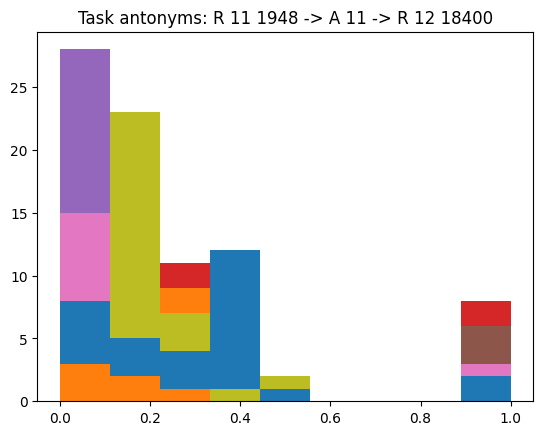

In [ ]:
from matplotlib import pyplot as plt
import jax.numpy as jnp
from micrlhf.utils.load_sae import sae_encode, weights_to_resid
from micrlhf.llama import LlamaBlock, LlamaAttention, LlamaInputs
from tqdm.auto import tqdm
import gc


def check_if_single_token(token):
    return len(tokenizer.tokenize(token)) == 1

# !rm data/attn_out/*.png
# def plot_attn(task_name):

task_name = "antonyms"

task = tasks[task_name]

print(task_name, len(task))

# task = {
#     k:v for k,v in task.items() if check_if_single_token(k) and check_if_single_token(v)
# }

print(len(task))

pairs = list(task.items())

batch_size = 8
n_shot=5
max_seq_len = 128
seed = 10

prompt = "Follow the pattern:\n{}"

runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot,
                max_seq_len=max_seq_len, seed=seed,
                prompt=prompt, use_same_examples=False)

layers = [11, 12] #, 13, 14]
circuitizer = Circuitizer(llama, tokenizer, runner, layers, prompt)




task_source_resid_features = {11: detectors["features"]}
# task_source_resid_features = {11: detectors[task_name]}
# task_target_resid_features = {12: [28800, 16172, 19051,  3925, 22162, 27165, 24640, 26427, 31442,
#         1425, 25273,  6685, 25966,  5854, 29007, 30363],}#[]}
task_target_resid_features = {12: executors["features"],}#[]}
# task_target_resid_features = {12: executors[task_name]}
# task_attn_out_features = {11: [4080]}
task_attn_out_features = {}
for layer in layers[:-1]:
    resid_sae = circuitizer.get_sae(layer=layer)
    source_resid_features = task_source_resid_features.get(layer, [])
    attn_out_features = task_attn_out_features.get(layer, [])
    target_resid_features = task_target_resid_features.get(layer + 1, [])
    if not source_resid_features or not (attn_out_features or target_resid_features):
        continue

    # qk_n.named_shape
    # out_raw = jnp.einsum("bokp,bkqso->bskqp", v, qk)
    # out_n = pz.nx.wrap(out_raw, "batch", "seq", "kv_heads", "q_rep", "projection")
    # out = attn_layer.attn_value_to_output(out_n)

    next_sae = circuitizer.get_sae(layer=layer + 1)
    attn_sae = circuitizer.get_sae(layer=layer, label="attn_out")
    resid_sae = {k: v.astype(jnp.float32) for k, v in resid_sae.items()}
    attn_sae = {k: v.astype(jnp.float32) for k, v in attn_sae.items()}
    next_sae = {k: v.astype(jnp.float32) for k, v in next_sae.items()}
    
    new_source = []
    for source_resid_feature in source_resid_features:
        if detectors["heatmap"][detectors["task_names"].index(task_name)][detectors["features"].index(source_resid_feature)] < 0.3:
            continue
        new_source.append(source_resid_feature)
    source_resid_features = new_source
    new_target = []
    for target_resid_feature in target_resid_features:
        if executors["heatmap"][executors["task_names"].index(task_name)][executors["features"].index(target_resid_feature)] < 0.3:
            continue
        new_target.append(target_resid_feature)
    target_resid_features = new_target

    # layer = 12
    for source_resid_feature in source_resid_features:
        biggest_feature = circuitizer.ie_resid[layer].mean((0, 1)).argmax().tolist()
        attn_features = circuitizer.ie_attn[layer].mean((0, 1))
        biggest_attn_feature = jnp.argsort(attn_features)[-2]
        # source_resid_feature = biggest_feature
        # attn_out_feature = biggest_attn_feature
        r_pre = circuitizer.resids_pre[layer].astype(jnp.float32)
        r_mid = circuitizer.resids_mid[layer].astype(jnp.float32)
        attn_out = r_mid - r_pre
        _, pre_encodings, recon = sae_encode(resid_sae, r_pre)
        pre_encodings = pre_encodings * jnp.zeros(pre_encodings.shape[-1]).at[source_resid_feature].set(1)
        err_r = r_pre - recon
        _, attn_encodings, _ = sae_encode(attn_sae, attn_out)
        r_other = weights_to_resid(pre_encodings, resid_sae) + err_r
        attn_subblock = circuitizer.llama.select().at_instances_of(LlamaBlock).pick_nth_selected(layer).at_instances_of(pz.nn.Residual).pick_nth_selected(0).get().delta
        attn_layer = attn_subblock.select().at_instances_of(LlamaAttention).pick_nth_selected(0).get()
        attn_ln = attn_subblock.select().at_instances_of(pz.nn.RMSLayerNorm).pick_nth_selected(0).get()
        r_other_n = pz.nx.wrap(r_other, "batch", "seq", "embedding")
        attn_input = attn_ln(r_other_n)
        v_n = attn_layer.input_to_value(attn_input)
        # v = v_n.unwrap("batch", "seq", "kv_heads", "projection")
        qk = circuitizer.qk[layer]
        qk_n = pz.nx.wrap(qk, "batch", "kv_heads", "q_rep", "seq", "kv_seq")
        out_n = attn_layer.attn_value_to_output((qk_n, v_n))
        out = out_n.unwrap("batch", "seq", "embedding").astype(jnp.float32)
        _, alt_attn_encodings, _ = sae_encode(attn_sae, out)

        # for attn_out_feature in attn_out_features:
        #     proportions_feature = alt_attn_encodings[..., attn_out_feature] / attn_encodings[..., attn_out_feature]
        #     proportions_feature = jax.nn.relu(jnp.minimum(proportions_feature, 1))
        #     plt.title(f"R {layer} {source_resid_feature} -> A {layer} {attn_out_feature}")
        #     plt.hist(proportions_feature.flatten().tolist(), bins = jnp.linspace(0, 1, 10))
        #     plt.xlabel("Proportion of feature activation")
        #     plt.show()
        
        next_resid = circuitizer.resids_pre[layer + 1].astype(jnp.float32)
        _, target_encodings, _ = sae_encode(next_sae, next_resid)
        # _, alt_target_encodings, _ = sae_encode(next_sae, next_resid + (out - attn_out))
        _, alt_target_encodings, _ = sae_encode(next_sae, next_resid + (attn_out - 5 * out))
        # _, alt_target_encodings, _ = sae_encode(next_sae, attn_out)

        for target_resid_feature in target_resid_features:
            proportions_feature = alt_target_encodings[..., target_resid_feature] / target_encodings[..., target_resid_feature]

            if (source_resid_feature == 11050):
                print(target_resid_feature)
                # print(target_encodings[..., target_resid_feature][0])
                proportions_feature = 1 - jax.nn.relu(jnp.minimum(1, proportions_feature))
                print(proportions_feature[~jnp.isnan(proportions_feature)])


            proportions_feature = 1 - jax.nn.relu(jnp.minimum(1, proportions_feature))
            proportions_feature = proportions_feature[~jnp.isnan(proportions_feature)]
            if not proportions_feature.size:
                continue
            if proportions_feature.max() < 0.1:
                continue
            plt.title(f"Task {task_name}: R {layer} {source_resid_feature} -> A {layer} -> R {layer+1} {target_resid_feature}")
            plt.hist(proportions_feature.flatten().tolist(), bins = jnp.linspace(0, 1, 10))
            # try:
            #     plt.hist(proportions_feature.flatten().tolist())#, bins = jnp.linspace(0, 1, 10))
            # except ValueError:
            #     plt.close()
            #     continue
            # plt.xlabel("Proportion of feature activation")
            # plt.savefig(f"data/attn_out/{task_name}_{layer}_{source_resid_feature}_{layer}_{layer+1}_{target_resid_feature}.png")
            # plt.close()

            # plt.show()

# for detector_tni, task_name in enumerate(tqdm(detectors["task_names"])):
# # task_name = "antonyms"
# # task_name = "location_language"
#     plot_attn(task_name)
#     gc.collect()

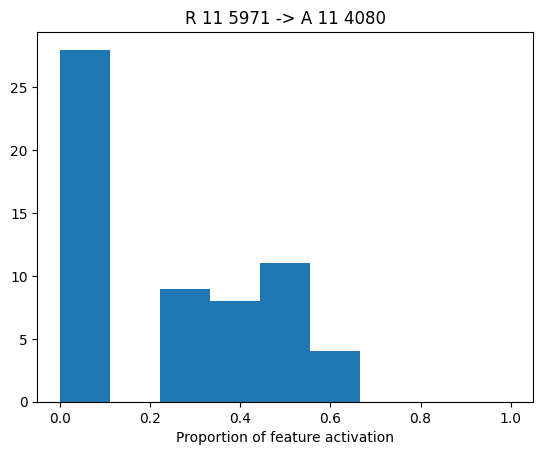

8.807933


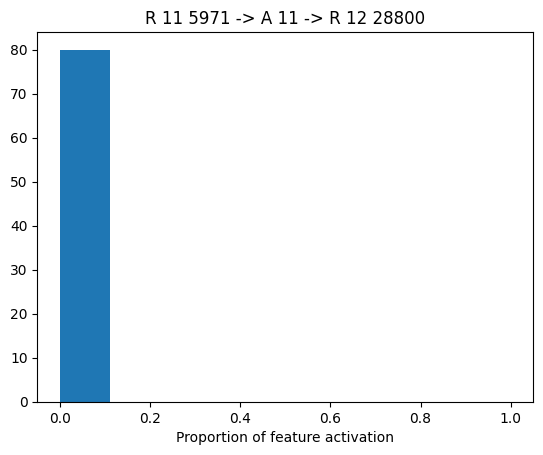

6.7455096


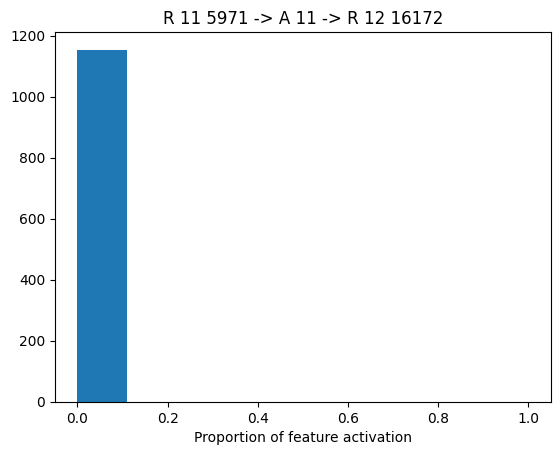

3.4522972


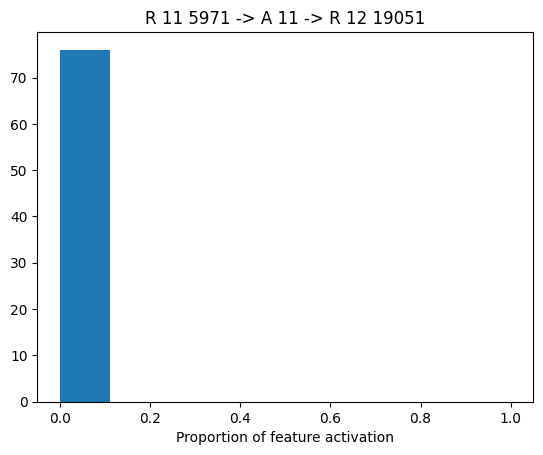

2.933157


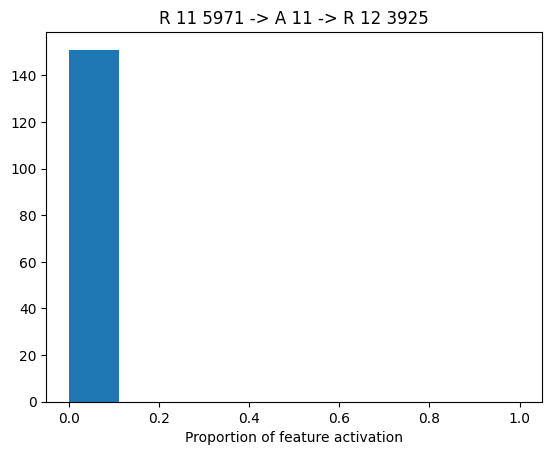

2.151169


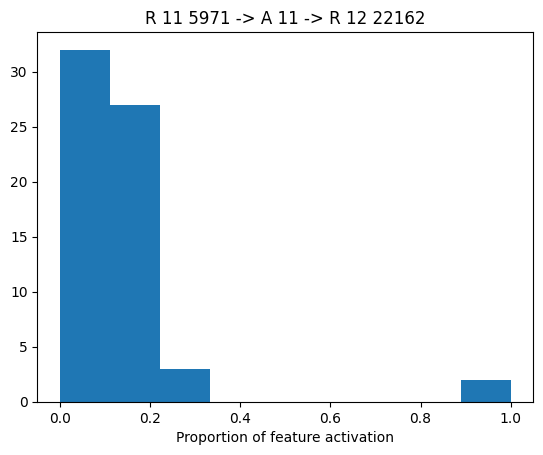

2.5086749


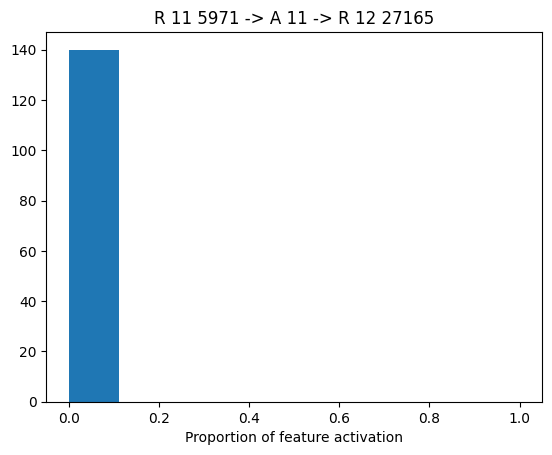

1.88948


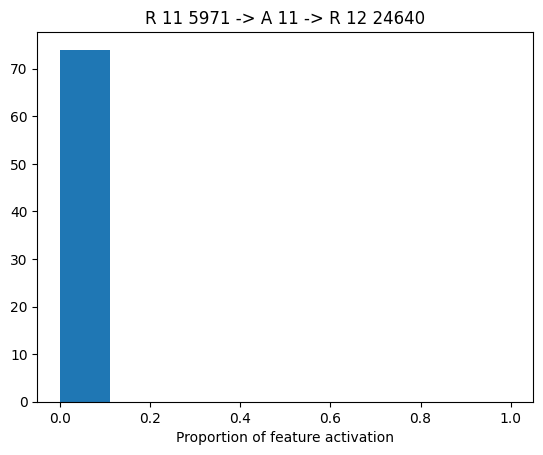

2.9522076


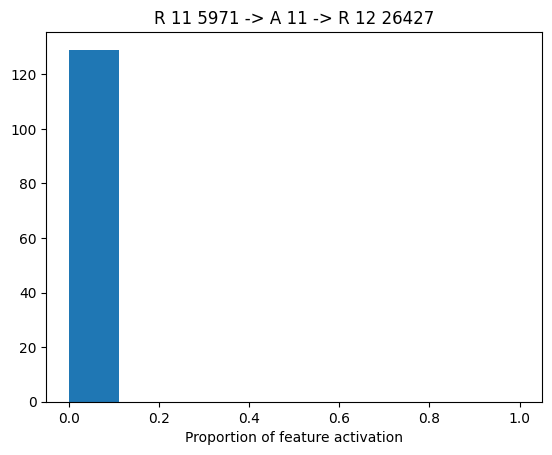

2.037872


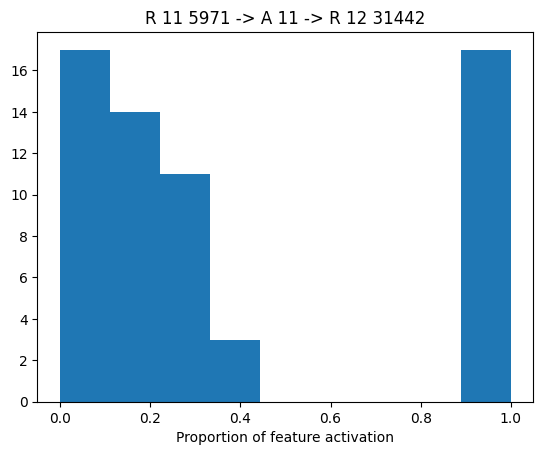

2.2260008


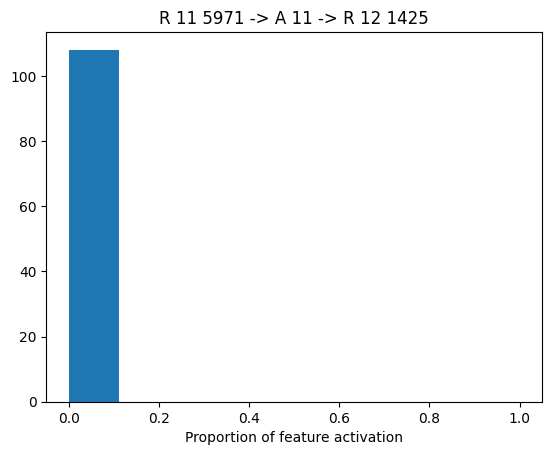

4.012281


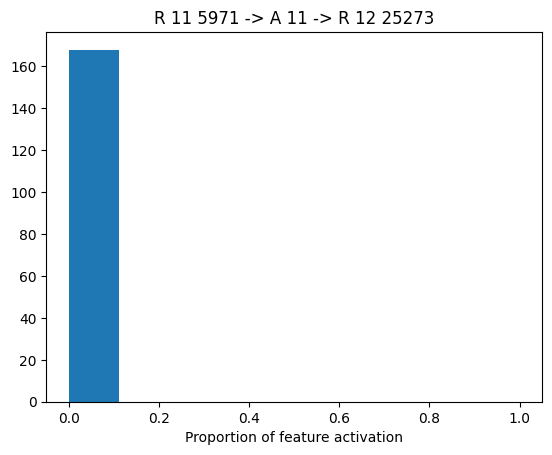

3.353037


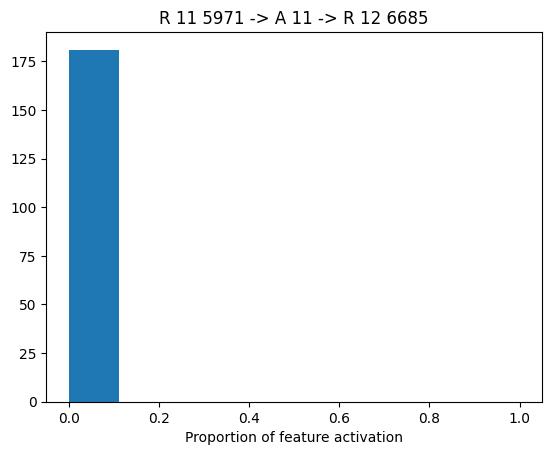

1.5142953


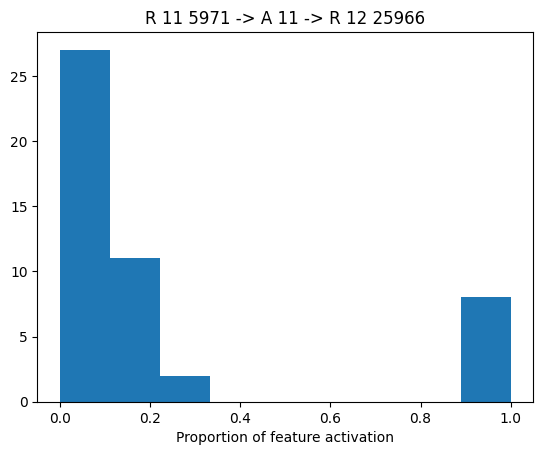

2.431318


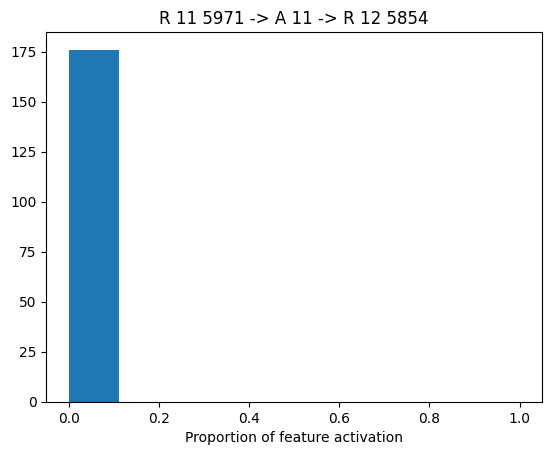

3.0441122


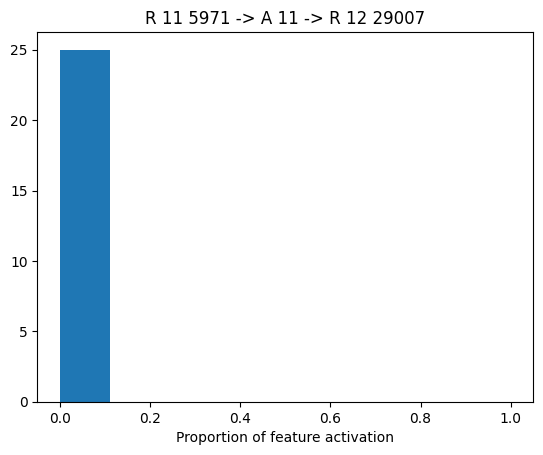

1.7817708


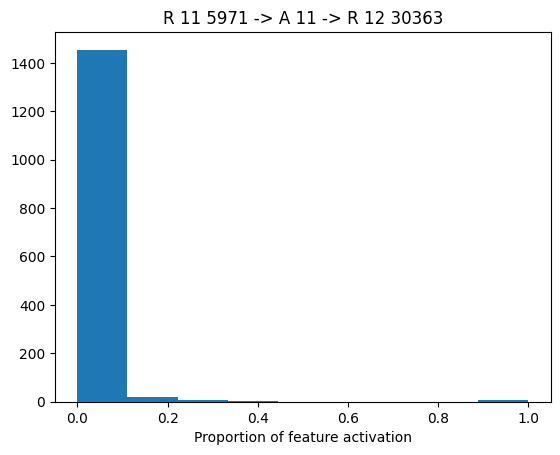

In [ ]:
# jax.lax.top_k((circuitizer.ie_resid[12] * circuitizer.masks["arrow"][..., None]).mean((0, 1)), 16)
jax.lax.top_k((target_encodings * circuitizer.masks["arrow"][..., None]).mean((0, 1)), 16)

[# jax.Array float32(16,) ≈0.047 ±0.044 [≥0.018, ≤0.2] nonzero:16
   Array([0.20175186, 0.08991919, 0.06919241, 0.04634359, 0.04184751,
          0.04144004, 0.03790932, 0.03438158, 0.03435165, 0.03256107,
          0.02791193, 0.02244019, 0.02015262, 0.01917463, 0.01851204,
          0.01797299], dtype=float32)
 ,
 # jax.Array int32(16,) [≥1_425, ≤31_442] nonzero:16
   Array([28800, 16172, 19051,  3925, 22162, 27165, 24640, 26427, 31442,
           1425, 25273,  6685, 25966,  5854, 29007, 30363], dtype=int32)
 ]